# Extract and analyze a movie

Industries such as Media & Entertainment, Advertising and Sports manage vast inventories of professionally produced videos, including TV shows, movies, news, sports events, documentaries, and more. To effectively extract insights from this type of video content, users require information such as video summaries, scene-level analysis, IAB classifications for ad targeting, and speaker identification.

> [IAB categories](https://smartclip.tv/adtech-glossary/iab-categories/) are standard classifications for web content that are developed by the Interactive Advertising Bureau (IAB). These categories are used to sort advertisers into industries and segments.

In this lab, we will use BDA Video to extract and analyze a sample open-source movie Meridian, walking through the process and exploring the generated outputs.
![video moderation](../static/bda-video-scene.png)

## Prerequisits

### Retrieve saved values from previous notebooks

To run this notebook, you need to have run the previous notebook: [00_prerequisites.ipynb](./00-prequisites.ipynb), where you installed package dependencies and gathered some information from the SageMaker environment.

In [9]:
store -r

In [11]:
data_bucket = session["bucket"]
data_prefix = "bda/video"
output_prefix = "bda/video/ouput"

In [12]:
import boto3
import json
import uuid
import utils

bda_client = boto3.client('bedrock-data-automation')
bda_runtime_client = boto3.client('bedrock-data-automation-runtime')
s3_client = boto3.client('s3')

## Create a BDA project with a standard output configuration for videos
To start a BDA job, you need a BDA project, which organizes both standard and custom output configurations. This project is reusable, allowing you to apply the same configuration to process multiple videos that share the same settings.

In the code snippet below, we create a BDA project with standard output configurations for video modality. These configurations can be tailored to extract only the specific information you need. In this lab, we will enable the below video outputs:
- Full video summary
- Scene summaries
- IAB categories on the scene level
- Full audio transcript
- Text in video with bounding-boxes

For a complete API reference for creating a BDA project, refer to this [document](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-data-automation/client/create_data_automation_project.html).

In [13]:
response = bda_client.create_data_automation_project(
    projectName=f'bda-workshop-video-project-{str(uuid.uuid4())[0:4]}',
    projectDescription='BDA workshop video sample project',
    projectStage='DEVELOPMENT',
    standardOutputConfiguration={
        'video': {
            'extraction': {
                'category': {
                    'state': 'ENABLED',
                    'types': ['TEXT_DETECTION','TRANSCRIPT'],
                },
                'boundingBox': {
                    'state': 'ENABLED',
                }
            },
            'generativeField': {
                'state': 'ENABLED',
                'types': ['VIDEO_SUMMARY','SCENE_SUMMARY','IAB'],
            }
        }
    }
)

The create_data_automation_project API will return the project ARN, which we will use it to invoke the video analysis task.

In [14]:
video_project_arn = response.get("projectArn")
print("BDA video project ARN:", video_project_arn)

BDA video project ARN: arn:aws:bedrock:us-west-2:616825853690:data-automation-project/85b022df8ec3


## Start an asynchronous BDA task to extract and analyze a movie
In this section, we will use a open-source movie Meridian, and extract and analyze it using BDA, applying the configuration defined in the BDA project. We will then review the output to gain a deeper understanding of how BDA performs video extraction and analysis.

### Prepare the sample video

In [15]:
sample_video_movie = './NetflixMeridian.mp4'
!curl "https://d1xvhy22zmw77y.cloudfront.net/tmp/NetflixMeridian.mp4" --output NetflixMeridian.mp4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.1M  100 47.1M    0     0  46.2M      0  0:00:01  0:00:01 --:--:-- 46.3M


Let's display the video. [Meridian](https://en.wikipedia.org/wiki/Meridian_(film)) is a test movie from Netflix, we use it to showcase how BDA works with video extraction. As you can see, it is a classic-style movie composed of multiple scenes.

In [16]:
from IPython.display import Video
Video(sample_video_movie, width=800)

To analyze the video using BDA, we need to upload it to an S3 bucket that BDA can access. 

In [17]:
s3_key = f'{data_prefix}/{sample_video_movie.split("/")[-1]}'
s3_client.upload_file(sample_video_movie, data_bucket, s3_key)

### Start BDA task
We will now invoke the BDA API to process the uploaded video. You need to provide the BDA project ARN that we created at the beginning of the lab and specify an S3 location where BDA will store the output results.

For a complete API reference for invoke a BDA async task, refer to this [document](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-data-automation-runtime/client/invoke_data_automation_async.html).

In [18]:
response = bda_runtime_client.invoke_data_automation_async(
    inputConfiguration={
        's3Uri': f's3://{data_bucket}/{s3_key}'
    },
    outputConfiguration={
        's3Uri': f's3://{data_bucket}/{output_prefix}'
    },
    dataAutomationConfiguration={
        'dataAutomationArn': video_project_arn,
        'stage': 'DEVELOPMENT'
    },
    notificationConfiguration={
        'eventBridgeConfiguration': {
            'eventBridgeEnabled': False
        }
    }
)

The `invoke_data_automation_async` API is asynchronous. It returns an invocation task identifier, `invocationArn`. We can then use another API `get_data_automation_status` to monitor the task's status until it completes.

> In production workloads, an event-driven pattern is recommended. Allow BDA to trigger the next step once the task is complete. This can be achieved by configuring the notificationConfiguration in the invoke task, which will send a notification to a subscribed AWS service, such as a Lambda function. Alternatively, you can set up an S3 trigger on the bucket where BDA will drop the results.

In [19]:
invocation_arn = response.get("invocationArn")
print("BDA task started:", invocation_arn)

BDA task started: arn:aws:bedrock:us-west-2:616825853690:data-automation-invocation/d774293d-7a15-43ba-bea2-05ee3d39d03f


In this lab, we will use the loop below to monitor the task by calling the `get_data_automation_status` API every 5 seconds until the task is complete.

This video will take ~5-10 minutes.

In [20]:
import time
from IPython.display import clear_output
from datetime import datetime

status, status_response = None, None
while status not in ["Success","ServiceError","ClientError"]:
    status_response = bda_runtime_client.get_data_automation_status(
        invocationArn=invocation_arn
    )
    status = status_response.get("status")
    clear_output(wait=True)
    print(f"{datetime.now().strftime('%H:%M:%S')} : BDA video task: {status}")
    time.sleep(5)

output_config = status_response.get("outputConfiguration",{}).get("s3Uri")
print("Ouput configureation file:", output_config)

21:19:26 : BDA video task: Success
Ouput configureation file: s3://workshop-sagemakerdefaultbucket-z635st4uwwc8/bda/video/ouput/d774293d-7a15-43ba-bea2-05ee3d39d03f/job_metadata.json


## Access the BDA analysis result
The `get_data_automation_status` API returns an S3 URI containing the result configuration, which provides the S3 location where BDA outputs the extraction results. We will then parse this file to retrieve the result path.

In [21]:
config_data = utils.read_json_on_s3(output_config,s3_client)
print(json.dumps(config_data, indent=4))

{
    "job_id": "d774293d-7a15-43ba-bea2-05ee3d39d03f",
    "job_status": "PROCESSED",
    "semantic_modality": "VIDEO",
    "output_metadata": [
        {
            "asset_id": 0,
            "segment_metadata": [
                {
                    "standard_output_path": "s3://workshop-sagemakerdefaultbucket-z635st4uwwc8/bda/video/ouput/d774293d-7a15-43ba-bea2-05ee3d39d03f/0/standard_output/0/result.json"
                }
            ]
        }
    ]
}


As shown above, the BDA output configuration file contains metadata about the BDA result, including the job ID, status, modality, and the S3 location of the actual result JSON. We will now download this result file to verify the output.

In [22]:
from IPython.display import JSON

result_uri = config_data["output_metadata"][0]["segment_metadata"][0]["standard_output_path"]
result_data = utils.read_json_on_s3(result_uri,s3_client)

JSON(result_data)

<IPython.core.display.JSON object>

## Review the result
The BDA video analysis result contains a detailed breakdown of information, organized by video and scene level.
> A video scene is a sequence of shots that form a coherent unit of action or narrative within the video.

### Full video summary

Let's take a look at the video level summary - it distills the key themes, events, and information presented throughout the video into a concise summary. 

In [23]:
print(result_data["video"]["summary"])

This video presents a series of scenes depicting various locations and events in a nostalgic, cinematic style, likely set in the 1940s or 1950s. The narrative begins with a bustling urban street scene in Los Angeles, showcasing vintage cars, streetcars, and pedestrians in a vibrant commercial district. The scene includes prominent landmarks like the "HOLLYWOOD" sign and a movie theater marquee.

The video then shifts to the exterior of the Earl Carroll Theatre, a historic entertainment venue in a lively city environment, and the Florentine Gardens, an iconic entertainment destination in Zanzibar, capturing the elegance and grandeur of these iconic establishments.

The narrative then delves into a more mysterious and suspenseful storyline, centered around a group of individuals who went missing after visiting a rock formation near El Matador. Two men, one seemingly a detective or law enforcement officer, discuss the strange circumstances surrounding the disappearance, including a witnes

### Full video transcription
At the video level, we also receive the full transcript based on the video's audio, with speakers identified.

In [24]:
print(result_data["video"]["transcript"]["representation"]["text"])

   [spk_0]: So these guys just disappeared. [spk_1]: Yeah, on that stretch of road right above El Matador. You know it. With the big rock. That's right, yeah.

[spk_2]: You know, Mickey Cohen used to take his associates out there, get him a bond voyage.

[spk_1]: Mob heads? No, not this time. One of these guys was a school teacher. Next guy, he sold insurance, and the last guy, he was retired. Any connection? Mm. I mean, I checked them all out. There's no criminal records, no association in any criminal organizations. One of the guys was arrested for drunk driving a long time ago. They were all divorced.

[spk_2]: Well, in that case, maybe you don't want to go out there, boss.

[spk_1]: What are you, a comedian? If that's the case, you sure don't want to go out there.

[spk_2]: Yeah, look, I know what happened, all right? They go out to the rock, they take that long, cold, slow swim to

[spk_1]: China. Suicide.

[spk_2]: It's been known to happen out there.

[spk_1]: Uh, not this time.

### Scene definition, summaries, and IAB categories 
BDA also generates a scene-level summary, as specified in the project configuration. Additionally, we get more metadata, including the start and end times of each scene, as well as the [IAB](https://en.wikipedia.org/wiki/Interactive_Advertising_Bureau) categories classified based on the scene content.

In [25]:
for scene in result_data["scenes"]:
    iabs = []
    if scene.get("iab_categories"):
        for iab in scene["iab_categories"]:
            iabs.append(iab["category"])
        
    print(f'[{scene["start_timecode_smpte"]} - {scene["end_timecode_smpte"]}] {", ".join(iabs)}')
    print(scene["summary"])
    print()

[00:00:00;00 - 00:00:15;19] 
The video showcases a bustling urban street scene from the past, likely the 1940s or 1950s. It depicts a lively city street in Los Angeles, with vintage cars, streetcars, and pedestrians lining the sidewalks. The street is lined with historic buildings, storefronts, and signs, including the prominent "J.G. BENNEY CO" and "HOLLYWOOD" signs. The scene captures the vibrant atmosphere of a commercial district, with people walking along the sidewalks and vehicles passing by. The video also features a movie theater marquee advertising a film called "The Beginning or the End," adding to the nostalgic and cinematic ambiance.

[00:00:15;20 - 00:00:20;03] 
The video showcases the exterior of the Earl Carroll Theatre, a historic theater located in a bustling urban area. The theater's facade features prominent signage, including the name "EARL CARROE THEATRE" and "THE THEATRE". The surrounding streets are lined with palm trees, creating a tropical atmosphere. Pedestria

### Granular audio transcripts
Granular transcripts are also available at the scene level. Under each scene, you can find a list named `audio_segments` with associated timestamps. This can support additional downstream analysis that requires detailed transcript information.

In [26]:
for scene in result_data["scenes"]:
    for trans in scene["audio_segments"]:
        print(f'[{trans["start_timestamp_millis"]/1000} - {trans["end_timestamp_millis"]/1000}] {trans["text"]}')

[26.85 - 29.59] So these guys just disappeared.
[30.93 - 34.27] Yeah, on that stretch of road right above El Matador.
[35.099 - 35.959] You know it.
[36.49 - 39.029] With the big rock. That's right, yeah.
[40.189 - 44.86] You know, Mickey Cohen used to take his associates out there, get him a bond voyage.
[45.509 - 54.599] Mob heads? No, not this time. One of these guys was a school teacher. Next guy, he sold insurance, and the last guy, he was retired.
[55.61 - 56.409] Any connection?
[56.979 - 57.689] Mm.
[58.59 - 60.0] I mean, I checked them all out.
[60.52 - 67.879] There's no criminal records, no association in any criminal organizations. One of the guys was arrested for drunk driving a long time ago.
[69.62 - 71.91] They were all divorced.
[72.769 - 75.83] Well, in that case, maybe you don't want to go out there, boss.
[76.73 - 80.36] What are you, a comedian? If that's the case, you sure don't want to go out there.
[80.769 - 85.809] Yeah, look, I know what happened, all right? T

### Frame level text extraction with bounding-boxes and confidence scores
Text extraction, along with bounding boxes and confidence scores, is available at the frame level. In the output JSON structure, frames are organized under each scene with captured timestamp. If text is detected at a given frame, you can find text_words and text_lines included at the frame level.

Let's plot the frames for a given scene with detected text, including their bounding boxes.

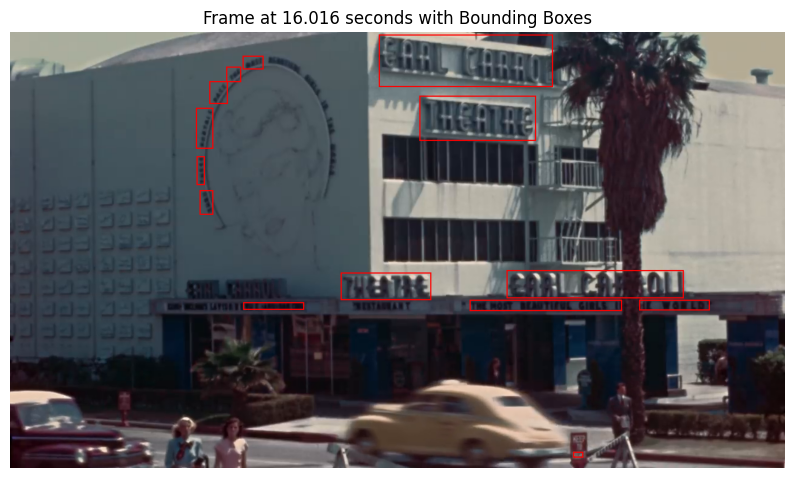

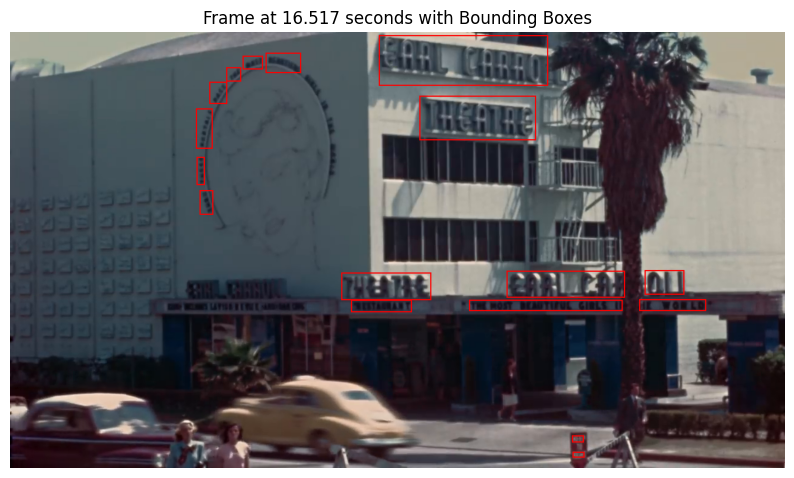

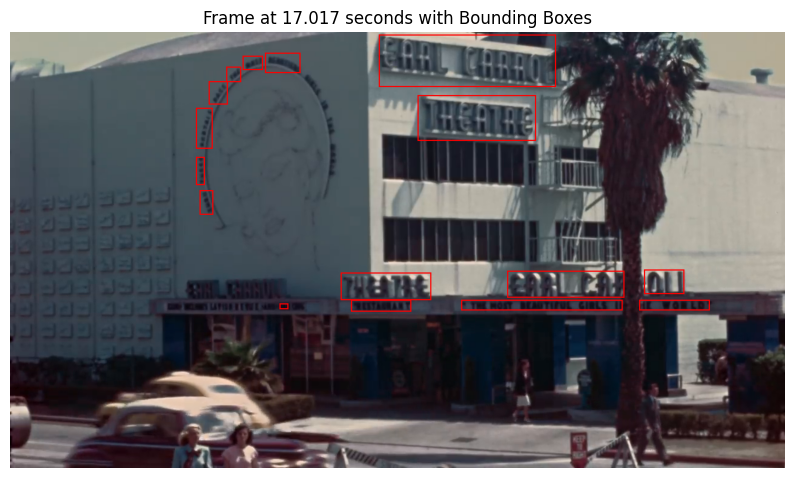

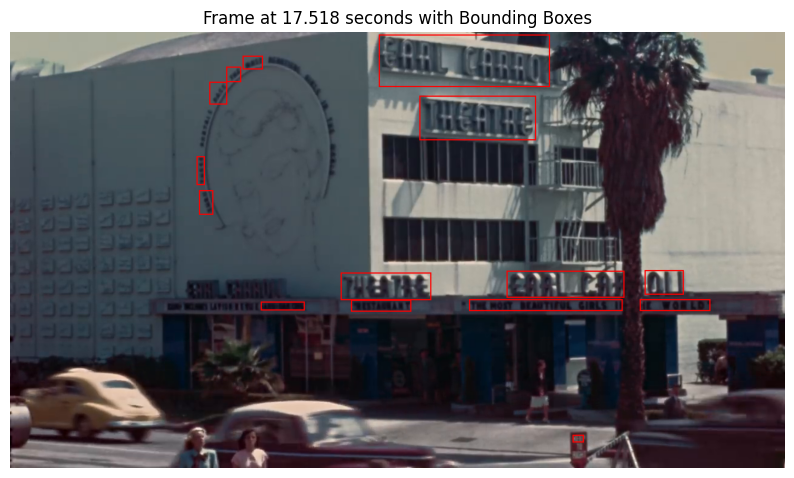

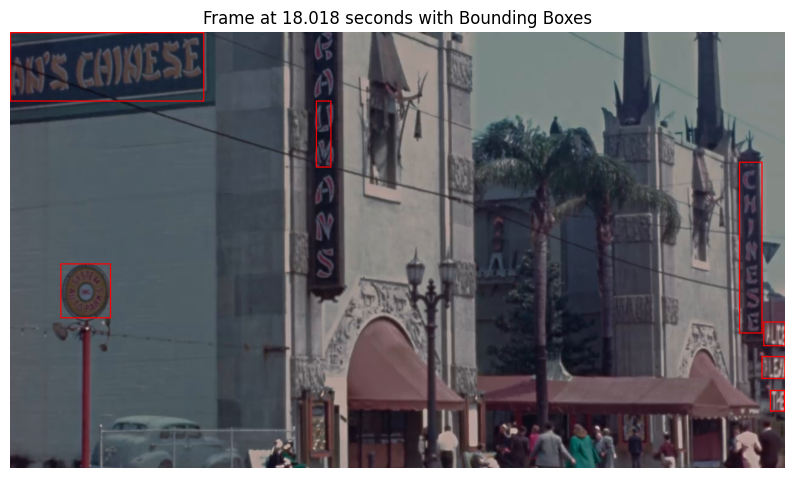

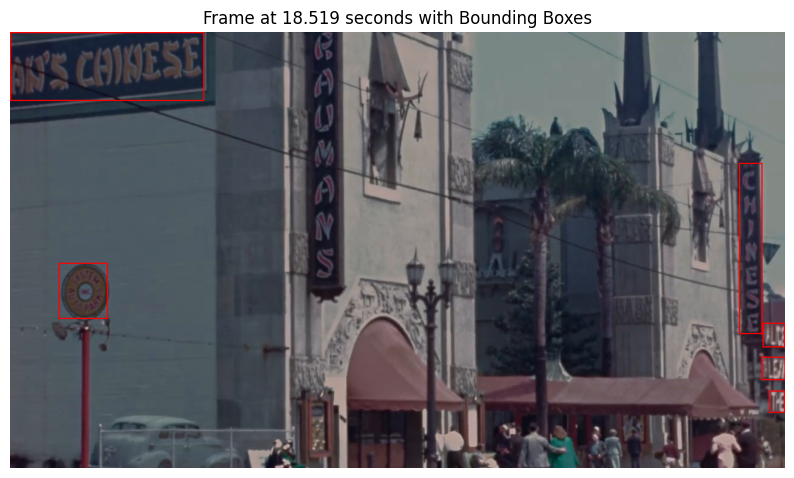

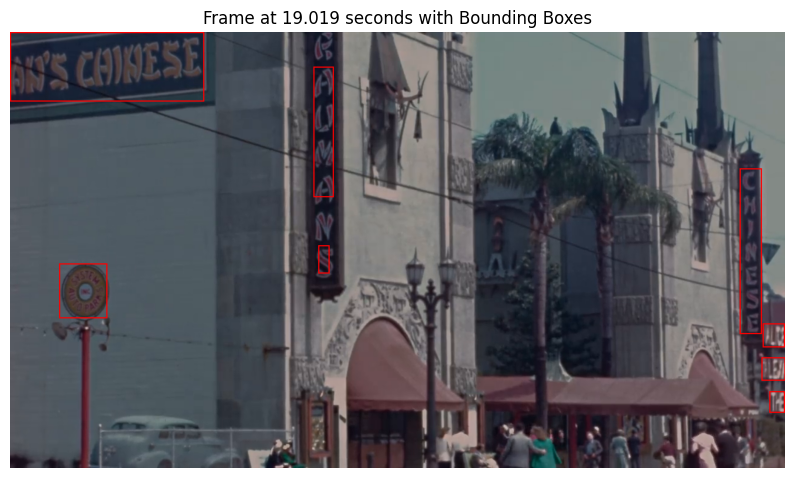

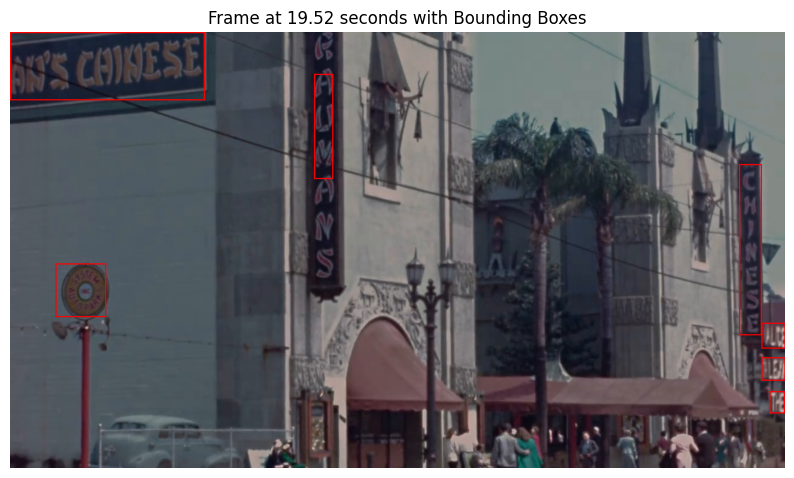

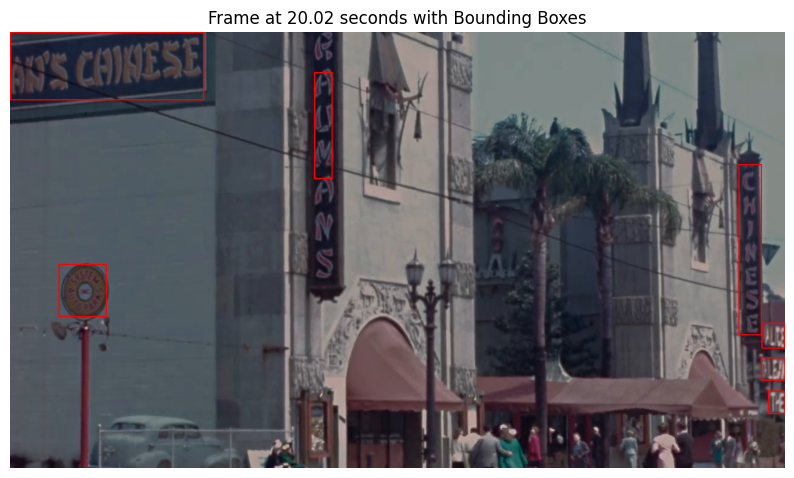

In [27]:
# plot all frames with boundingbox in the given scene
scene_index = 1 

width = result_data["metadata"]["frame_width"]
height = result_data["metadata"]["frame_height"]

from moviepy.video.io.VideoFileClip import VideoFileClip
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

with VideoFileClip(sample_video_movie) as video_clip:
    for scene in result_data["scenes"]:
        if scene["scene_index"] == scene_index:
            for frame in scene["frames"]:
                bboxes = []
                if frame.get("text_lines"):
                    for tl in frame["text_lines"]:
                        for l in tl["locations"]:
                            bbox = l["bounding_box"]
                            if bbox:
                                bboxes.append((
                                                width*bbox["left"], 
                                                height*bbox["top"], 
                                                width * (bbox["width"]+bbox["left"]), 
                                                height * (bbox["height"] + bbox["top"])
                                            ))
                if bboxes:
                    timestamp = frame["timestamp_millis"]/1000
                    frame = video_clip.get_frame(timestamp)  
                    frame_image = Image.fromarray(frame)
                    draw = ImageDraw.Draw(frame_image)
                    for box in bboxes:
                        draw.rectangle(box, outline="red", width=2)

                    plt.figure(figsize=(10, 6))
                    plt.imshow(frame_image)
                    plt.title(f"Frame at {timestamp} seconds with Bounding Boxes")
                    plt.axis("off")
                    plt.show()

## Summary
BDA video returns highly detailed metadata managed by the configuration. In this lab, we have enabled standard outputs required for media video analysis, using a movie as an example. You can explore the output JSON to discover more details. This lab does not cover moderation detection and analysis; for that, you can refer to the next lab, which uses a social media-style video as an example to better understand the moderation analysis offered by BDA video.

## Clean up

Delete the BDA project, blueprint, image, and result from S3.

In [28]:
# delete BDA project
response = bda_client.delete_data_automation_project(
    projectArn=video_project_arn
)
response

{'ResponseMetadata': {'RequestId': 'ad735e64-4389-4b38-b2c7-80b94931a56f',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'date': 'Tue, 04 Feb 2025 21:19:36 GMT',
   'content-type': 'application/json',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'ad735e64-4389-4b38-b2c7-80b94931a56f'},
  'RetryAttempts': 0}}

In [29]:
# delete uploaded image from S3
s3_client.delete_object(Bucket=data_bucket, Key=s3_key)

{'ResponseMetadata': {'RequestId': 'WR5JEC42ET6V2NTZ',
  'HostId': '1KjtDNXmN0wmBNp0End6/uDaBjlnP1Pu4dk9gKsFLSZ4aKI6/eOXH5/DJqbMLBGFJL001jJuMvA=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': '1KjtDNXmN0wmBNp0End6/uDaBjlnP1Pu4dk9gKsFLSZ4aKI6/eOXH5/DJqbMLBGFJL001jJuMvA=',
   'x-amz-request-id': 'WR5JEC42ET6V2NTZ',
   'date': 'Tue, 04 Feb 2025 21:19:37 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

In [30]:
# delete results from S3
utils.delete_s3_folder(data_bucket, output_config.replace("job_metadata.json","") ,s3_client)

AttributeError: module 'utils' has no attribute 'delete_s3_folder'